# Proyek Klasifikasi Gambar: Scientific Image Classification Dataset
- **Nama:** Konstan Aftop Anewata Ndruru
- **Email:** konstanaftopn@gmail.com
- **ID Dicoding:** konstan_aftop

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install kaggle
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import tensorflow as tf
import requests
import io

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import TFSMLayer  # untuk load SavedModel
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from google.colab import drive

# Set seed untuk reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"konstanaftopds","key":"06511574d33d253dfce381f0f8974c9a"}'}

In [5]:
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!kaggle datasets download -d rushilprajapati/data-final
if not os.path.exists('img_data'):
    os.makedirs('img_data')
!unzip data-final -d img_data

Streaming output truncated to the last 5000 lines.
  inflating: img_data/data/Non-scientific/image_1006.jpg  
  inflating: img_data/data/Non-scientific/image_1007.jpg  
  inflating: img_data/data/Non-scientific/image_1008.jpg  
  inflating: img_data/data/Non-scientific/image_1009.jpg  
  inflating: img_data/data/Non-scientific/image_101.jpg  
  inflating: img_data/data/Non-scientific/image_1010.jpg  
  inflating: img_data/data/Non-scientific/image_1011.jpg  
  inflating: img_data/data/Non-scientific/image_1012.jpg  
  inflating: img_data/data/Non-scientific/image_1013.jpg  
  inflating: img_data/data/Non-scientific/image_1014.jpg  
  inflating: img_data/data/Non-scientific/image_1015.jpg  
  inflating: img_data/data/Non-scientific/image_1016.jpg  
  inflating: img_data/data/Non-scientific/image_1017.jpg  
  inflating: img_data/data/Non-scientific/image_1018.jpg  
  inflating: img_data/data/Non-scientific/image_1019.jpg  
  inflating: img_data/data/Non-scientific/image_102.jpg  
  infla

## Data Preparation

### Data Loading

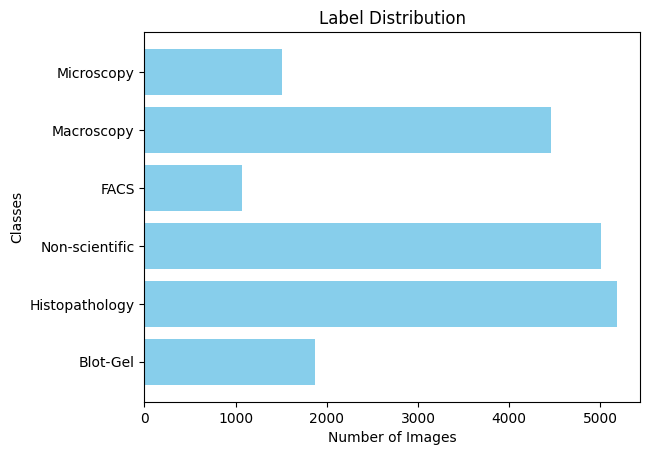

In [6]:
original_dataset_dir = 'img_data/data'

label_distribution = {}

for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        label_distribution[class_name] = num_images

classes = list(label_distribution.keys())
counts = list(label_distribution.values())

plt.barh(classes, counts, color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Label Distribution')

plt.show()

In [7]:
def count_unique_resolutions(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        total_images += num_images

        unique_sizes = set()

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        print(f"{subdir}: {len(unique_sizes)} unique resolutions")

    print(f"\nTotal images: {total_images}")

count_unique_resolutions('img_data/data')


Blot-Gel: 1477 unique resolutions
Histopathology: 1 unique resolutions
Non-scientific: 1 unique resolutions
FACS: 933 unique resolutions
Macroscopy: 662 unique resolutions
Microscopy: 933 unique resolutions

Total images: 19105


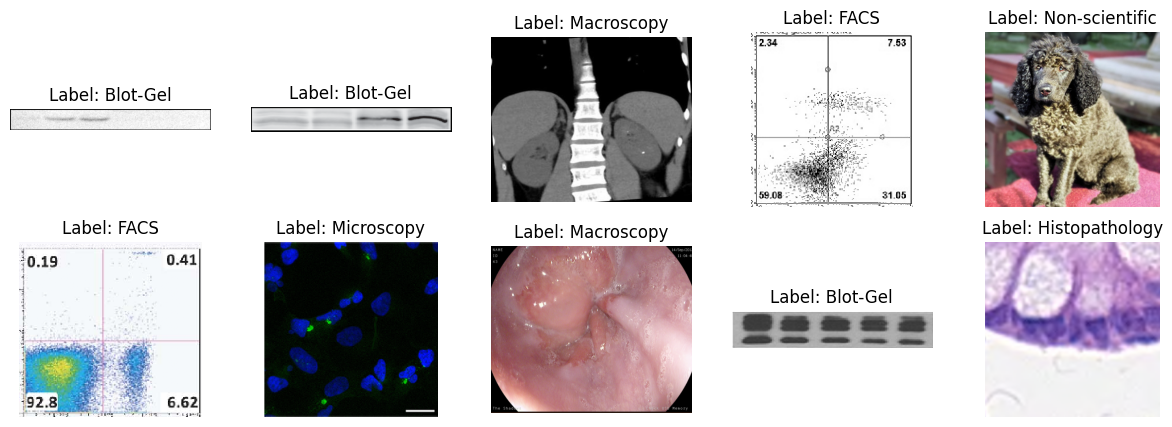

In [8]:
original_dataset_dir = 'img_data/data'

num_images_to_show = 10

image_paths = []

for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        random_images = random.sample(images, min(num_images_to_show, len(images)))
        for image in random_images:
            image_paths.append(os.path.join(class_dir, image))

random.shuffle(image_paths)


plt.figure(figsize=(15, 5))

for i, image_path in enumerate(image_paths[:num_images_to_show]):
    img = mpimg.imread(image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Label: {image_path.split(os.sep)[-2]}")
    plt.axis('off')

plt.show()

### Data Preprocessing

#### Split Dataset

In [9]:
def create_image_df(directory):
    img_paths = []
    labels = []

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_paths.append(os.path.join(subdir, file))
                labels.append(os.path.basename(subdir))

    df = pd.DataFrame({'image_path': img_paths, 'label': labels})
    return df

df = create_image_df('img_data/data')

In [10]:
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 13373
Validation set size: 2866
Test set size: 2866


In [11]:
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen= ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False
)

Found 13373 validated image filenames belonging to 6 classes.
Found 2866 validated image filenames belonging to 6 classes.
Found 2866 validated image filenames belonging to 6 classes.


## Modelling

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Misalnya input gambar 64x64 dengan 3 channel (RGB)
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 92s 200ms/step - accuracy: 0.7240 - loss: 0.8553 - val_accuracy: 0.9246 - val_loss: 0.2468
Epoch 2/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - accuracy: 0.9031 - loss: 0.2996 - val_accuracy: 0.9253 - val_loss: 0.2449
Epoch 3/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 94s 226ms/step - accuracy: 0.9236 - loss: 0.2355 - val_accuracy: 0.9550 - val_loss: 0.1484
Epoch 4/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.9471 - loss: 0.1686 - val_accuracy: 0.9246 - val_loss: 0.2482
Epoch 5/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 76s 182ms/step - accuracy: 0.9532 - loss: 0.1585 - val_accuracy: 0.9543 - val_loss: 0.1561
Epoch 6/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 76s 181ms/step - accuracy: 0.9617 - loss: 0.1213 - val_accuracy: 0.9592 - val_loss: 0.1552


## Evaluasi dan Visualisasi

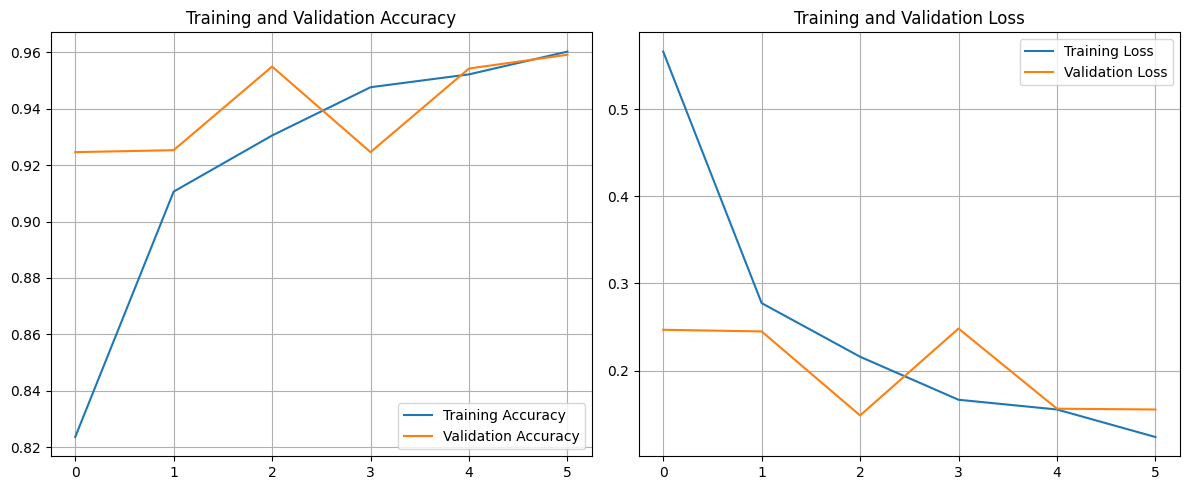

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
loss_train, acc_train = model.evaluate(train_generator)
loss_test, acc_test = model.evaluate(test_generator)

results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Loss': [loss_train, loss_test],
    'Accuracy': [acc_train, acc_test]
})

results

418/418 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.9692 - loss: 0.0995
2866/2866 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9556 - loss: 0.1410


,Dataset,Loss,Accuracy
0,Train,0.094661,0.971884
1,Test,0.140478,0.955338


In [16]:
y_pred=model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

report = classification_report(y_true, y_pred_classes, target_names=['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific'])
print(report)

2866/2866 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
                precision    recall  f1-score   support

      Blot-Gel       0.91      0.94      0.92       281
          FACS       1.00      0.98      0.99       160
Histopathology       0.98      0.99      0.99       777
    Macroscopy       0.94      0.94      0.94       670
    Microscopy       0.86      0.79      0.83       226
Non-scientific       0.97      0.98      0.98       752

      accuracy                           0.96      2866
     macro avg       0.94      0.94      0.94      2866
  weighted avg       0.95      0.96      0.95      2866



## Konversi Model

In [17]:
class_names = list(train_generator.class_indices.keys())

tflite_dir = 'tflite_model/'
os.makedirs(tflite_dir, exist_ok=True)

save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

label_path = os.path.join(tflite_dir, 'label.txt')
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
converter.experimental_enable_resource_variables = False
tflite_model = converter.convert()

tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

2025-04-27 12:52:08.837380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745758328.857808    3851 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745758328.863942    3851 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-27 12:52:15.157223: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745758335.157421    3851 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Masukkan URL gambarmu (Kosongkan utk inferensi gambar default): https://thumbs.dreamstime.com/b/adrenal-glands-observed-their-anatomic-position-above-kidneys-93292948.jpg


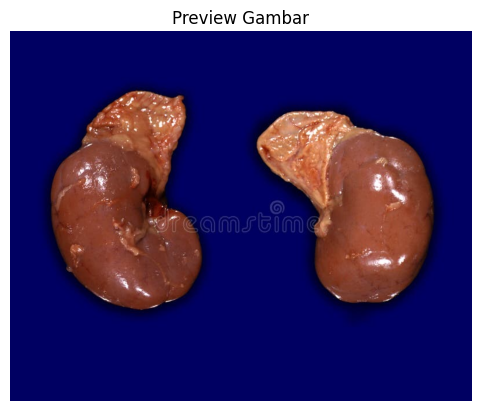

Predicted class : Macroscopy


In [23]:
# 1. Input URL
your_url = input("Masukkan URL gambarmu (Kosongkan utk inferensi gambar default): ")
if your_url.strip() == "":
    img_url = "https://clinical-sciences.ed.ac.uk/sites/default/files/imports/fileManager/NiS_Microscope_400x200.jpg"
else:
    img_url = your_url

# 2. Download gambar
response = requests.get(img_url)
img = Image.open(io.BytesIO(response.content)).convert('RGB')

# 3. Preview gambar
plt.imshow(img)
plt.title("Preview Gambar")
plt.axis('off')
plt.show()

# 4. Preprocessing
img = img.resize((224, 224))
input_data = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=0)

# 5. Load SavedModel pakai TFSMLayer
saved_model_path = "saved_model"  # Ganti path jika perlu
model = TFSMLayer(saved_model_path, call_endpoint="serving_default")

# 6. Inference
output_data = model(input_data)
output_tensor = list(output_data.values())[0]
output_tensor = output_tensor.numpy()

labels=list(train_generator.class_indices.keys())
# 7. Prediksi
predicted_class = np.argmax(output_tensor)
print("Predicted class :", labels[predicted_class])

In [24]:
!pip freeze > requirements.txt